In [1]:
import sys
from os import path 

scriptpath = ".."
sys.path.append(path.abspath(scriptpath))

from bashprocessing import Parser
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler

from tpot import TPOTClassifier

RANDOM = 1620 # Bacon's scientific method is born
TPOT = False

In [2]:
with open('../data/nl2bash.cm') as f1:
    benign = f1.readlines()

with open('../data/malicious.cm') as f2:
    malicious = f2.readlines()

In [3]:
# heavily imbalanced data - as always in security ...
print(len(benign))
print(len(malicious))

12607
123


# Creating test and validation sets

We just can't use sklearn's `train_test_split()` as is, because many malicious behavior commands have totally different pattern and purpose. Therefore, we need to find specific command subset, that characterize some family of malicious commands, and is in necessary amount to be present in both train and test sets.

*nix `/usr/bin/find` binary is often used query filesystem on behalf of specific files and their parameters. Heavily utilized by both system administrators and security threat actors during system enumeration. Some subset of `find` commands present in both datasets:

In [4]:
print(len([x for x in benign if 'find' in x]))

print(len([x for x in malicious if 'find' in x]))

7826
64


Similar situation with network connectivity - both valid commands and malicious callbacks (called *reverse shells*) have network information within (in our dataset all remote host specification is normalized to be `example.com`), and present in both datasets:

In [5]:
# commands that perform connections to remote hosts (normalized so host is specified as example.com)
print(len([x for x in benign if 'example.com' in x]))
print(len([x for x in malicious if 'example.com' in x]))

77
30


Both of these command patterns will be segregated to, so some subset is present in train set, and other subset in test set..

In [6]:
def give_test_by_pattern(inputlist, pattern, size=None):
    pattern_list = shuffle([x for x in inputlist if pattern in x], random_state=RANDOM)
    non_pattern_list = [x for x in inputlist if pattern not in x]
    
    if not size:
        size = int(0.5 * len(pattern_list))
    
    pattern_trainset = [x for x in pattern_list][size:]
    pattern_testset = [x for x in pattern_list][:size]

    trainset = pattern_trainset + non_pattern_list
    return trainset, pattern_testset

In [7]:
def create_datasets(benign, malicious, patterns):

    X_train, X_test, y_train, y_test = [], [], [], []
    cropped_train = [benign, malicious]

    for pattern in patterns:
        
        tr, te = give_test_by_pattern(cropped_train[1], pattern)
        X_test.extend(te)
        y_test.extend([1]*len(te))
        cropped_train[1] = tr

        tr, te = give_test_by_pattern(cropped_train[0], pattern, size=len(te))
        X_test.extend(te)
        y_test.extend([0]*len(te))
        cropped_train[0] = tr

    X_train, y_train = shuffle(cropped_train[0] + cropped_train[1], \
                                [0] * len(cropped_train[0]) + [1] * len(cropped_train[1]), \
                                random_state=RANDOM) 
    X_test, y_test = shuffle(X_test, y_test, random_state=RANDOM)
    return X_train, X_test, y_train, y_test


In [8]:
X_train_cm, X_test_cm, y_train, y_test = create_datasets(benign, malicious, ["find", "example.com", "python", "php"])
print(len(X_train_cm), len(X_test_cm))

12624 106


In [9]:
# sanity check
print(len(X_train_cm + X_test_cm))
print(len(y_train + y_test))
print(len(malicious + benign))

12730
12730
12730


# Encoding using `bashprocessing`

In [10]:
p = Parser(verbose=True)
cntr , corpus = p.tokenize(X_train_cm)
X_train = p.encode(mode="onehot", top_tokens=OH_DIMENSION)
print("\n",X_train.shape)


 (12624, 500)


In [11]:
p = Parser(verbose=True)
_,_ = p.parse(X_test_cm)
X_test = p.encode(mode="onehot", top_tokens=OH_DIMENSION)
print(X_test.shape)

(106, 500)


# RandomForestClassifier and Oversampling

If we train model on data as is we get all predictions as benign and accuracy of exact 50% (due to fast that our test set have exact same amount of values from both classes)..

In [12]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(y_pred)


0.5
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


This is due to fact that we have negligble count of malicious examples in our training set.  

In [13]:
def class_percentage(y):
    u,c = np.unique(y, return_counts=True)
    neg,pos = c
    print(f"Malicious commands: {round(pos*100/(neg+pos),4)} %")

print("In test set:\n\t", end="")
class_percentage(y_test)
print("\nIn train set:\n\t", end="")
class_percentage(y_train)

In test set:
	Malicious commands: 50.0 %

In train set:
	Malicious commands: 0.5545 %


Therefore, we need to implement oversampling, so model is able to train itself on malicious examples.

In [14]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [15]:
print(X_train.shape)
print(X_train_resampled.shape)

(12624, 500)
(25108, 500)


In [16]:
print("\nIn resampled train set:\n\t", end="")
class_percentage(y_train_resampled)


In resampled train set:
	Malicious commands: 50.0 %


In [17]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_resampled, y_train_resampled)

y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.5283018867924528


In [18]:
print(y_pred)
print(np.array(y_test))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
[1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0
 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0]


Still predition is really poor and obviously biased towards benign class ...  
On train set we have pretty good pattern learning:

In [19]:
y_train_pred = rfc.predict(X_train_resampled)
print(accuracy_score(y_train_resampled, y_train_pred))

0.9986458499283097


# Trying TPOT

In [20]:
if TPOT: # may skip as is long
    tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
    tpot.fit(X_train, y_train)

    tpot.score(np.array(X_test), np.array(y_test))

# Attempt to use Deep Learning

In [22]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

torch.manual_seed(RANDOM)
np.random.seed(RANDOM)

In [23]:
X_trainT = torch.from_numpy(np.array(X_train_resampled, dtype='float32'))
y_trainT = torch.from_numpy(np.array(y_train_resampled, dtype='float32'))
X_testT = torch.from_numpy(np.array(X_test, dtype='float32'))
y_testT = torch.from_numpy(np.array(y_test, dtype='float32'))

## Arcihtecture selection

Trying to overfit model with small batch to understand, whether model can learn perfectly nonlinearity of the data.

In [24]:
hidden_nodes = [16, 64]

In [25]:
models = defaultdict(dict)

for n in hidden_nodes:
    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n,1),
        torch.nn.Sigmoid()
    )
    models[f"onelayer-hn{str(n)}"] = m

    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n, int(n/2), bias=True),
        torch.nn.BatchNorm1d(int(n/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(n/2),1),
        torch.nn.Sigmoid()
    )
    models[f"twolayers-hn{str(n)}"] = m

    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n, int(n/2), bias=True),
        torch.nn.BatchNorm1d(int(n/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(n/2),int(n/2)),
        torch.nn.BatchNorm1d(int(n/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(n/2),1),
        torch.nn.Sigmoid()
    )
    models[f"threelayers-hn{str(n)}"] = m

In [26]:
print(models[list(models.keys())[-1]])
print("\nTotal amount of models: ",len(models))

Sequential(
  (0): Linear(in_features=500, out_features=64, bias=True)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)

Total amount of models:  6


In [27]:
def plot_loss(loss_dict, title="Losses over number of epochs", lim=None):
    plt.title(title)
    for loss in loss_dict:
        plt.plot(loss_dict[loss][0:], label=loss)
    plt.xlabel('number of epochs')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    if lim:
        plt.ylim(lim)
    plt.show()

In [28]:
loss_values = defaultdict(list)
for model in models:
    print(f"[!] Training {model} model..")
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(models[model].parameters())
    for ep in range(1000):
        optimizer.zero_grad()
        output = models[model].forward(X_trainT[0:32])
        loss = criterion(output, y_trainT[0:32])
        loss.backward()
        optimizer.step()

        loss_values[model].append(loss.item()/32)

[!] Training onelayer-hn16 model..
[!] Training twolayers-hn16 model..
[!] Training threelayers-hn16 model..
[!] Training onelayer-hn64 model..
[!] Training twolayers-hn64 model..
[!] Training threelayers-hn64 model..


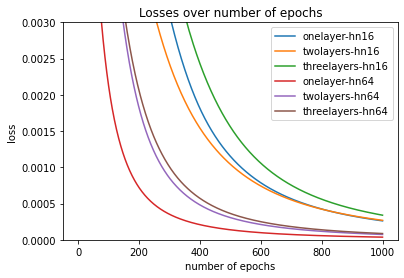

In [29]:
plot_loss(loss_values, lim=(0,0.003))

From here we see that for model in order to learn pattern in a data it's more important is to have higher number of nodes in a layer, than depth.  

All models with 64 nodes eventually were able to learn pattern almost perfectly, with no noticeable difference between two and three layers. More shallow models even after 1000 operations are not able to learn it perfectly, which means they're unable to get all level of data nonlinearity.

Try one more iteration of two layer models, with some range of nodes and reducing / not reducing node count in hidden layer.

In [30]:
hidden_nodes = [16, 32, 64]
models = defaultdict(dict)

for n in hidden_nodes:
    m = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n, int(n/2), bias=True),
        torch.nn.BatchNorm1d(int(n/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(n/2),1),
        torch.nn.Sigmoid()
    )
    models[f"twolayers-hn{str(n)}"] = m

    m = torch.nn.Sequential(
    torch.nn.Linear(OH_DIMENSION, n, bias=True),
    torch.nn.BatchNorm1d(n),
    torch.nn.ReLU(),
    torch.nn.Linear(n, n, bias=True),
    torch.nn.BatchNorm1d(n),
    torch.nn.ReLU(),
    torch.nn.Linear(n,1),
    torch.nn.Sigmoid()
    )
    models[f"twolayers-hn{str(n)}-samenr"] = m


In [31]:
loss_values = defaultdict(list)
for model in models:
    print(f"[!] Training {model} model..")
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(models[model].parameters())
    for ep in range(1000):
        optimizer.zero_grad()
        output = models[model].forward(X_trainT[0:32])
        loss = criterion(output, y_trainT[0:32])
        loss.backward()
        optimizer.step()

        loss_values[model].append(loss.item()/32)

[!] Training twolayers-hn16 model..
[!] Training twolayers-hn16-samenr model..
[!] Training twolayers-hn32 model..
[!] Training twolayers-hn32-samenr model..
[!] Training twolayers-hn64 model..
[!] Training twolayers-hn64-samenr model..


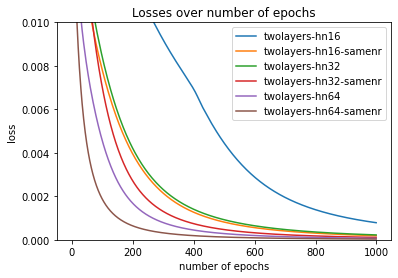

In [32]:
plot_loss(loss_values, lim=(0,0.01))

Ok, having two layers with 32 nodes and without node count decrease seem to be optimal archicture.

## Hyperparameter tuning

In [33]:
learning_rates = [0.0003, 0.001, 0.003, 0.01, 0.03]

In [34]:
n = 64
model = torch.nn.Sequential(
    torch.nn.Linear(OH_DIMENSION, n, bias=True),
    torch.nn.BatchNorm1d(n),
    torch.nn.ReLU(),
    torch.nn.Linear(n, n, bias=True),
    torch.nn.BatchNorm1d(n),
    torch.nn.ReLU(),
    torch.nn.Linear(n,1),
    torch.nn.Sigmoid()
    )

def weight_reset(m):
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

In [35]:
loss_values = defaultdict(list)
for lr in learning_rates:
    model.apply(weight_reset)
    print(f"[!] Training optimal model with lr: {lr}")
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for ep in range(200):
        optimizer.zero_grad()
        output = model.forward(X_trainT)
        loss = criterion(output, y_trainT)
        loss.backward()
        optimizer.step()

        loss_values[lr].append(loss.item()/len(y_trainT))

[!] Training optimal model with lr: 0.0003
[!] Training optimal model with lr: 0.001
[!] Training optimal model with lr: 0.003
[!] Training optimal model with lr: 0.01
[!] Training optimal model with lr: 0.03


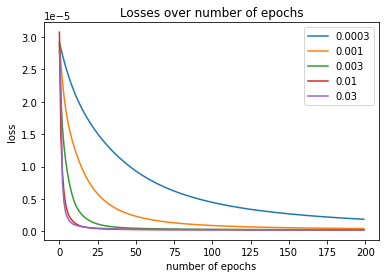

In [36]:
plot_loss(loss_values)

Increase in Learning Rate does not bring loss perturbations (at least in 0.0003-0.03 range), although no noticeable benefit in noticed above 0.003 value. Considering this as optimal value. 

In [37]:
OPTIMAL_LR = 0.003

## Dropout regularization

In [38]:
dropout = [0.2, 0.5]

In [39]:
models = defaultdict(dict)

models["no_dropout"] = model = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n,1),
        torch.nn.Sigmoid())

for rate in dropout:
    model = torch.nn.Sequential(
        torch.nn.Linear(OH_DIMENSION, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=rate),
        torch.nn.Linear(n, n, bias=True),
        torch.nn.BatchNorm1d(n),
        torch.nn.ReLU(),
        torch.nn.Linear(n,1),
        torch.nn.Sigmoid()
    )
    models[rate] = model

In [40]:
loss_values = defaultdict(list)

for model in models: 
    print(f"[!] Training: {model}")
    
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(models[model].parameters(), lr=OPTIMAL_LR)

    for ep in range(EPOCHS):

        optimizer.zero_grad()
        output = models[model].forward(X_trainT)

        loss = criterion(output, y_trainT)
        loss.backward()
        optimizer.step()

        loss_values[model].append(loss.item()/len(y_trainT))

[!] Training: no_dropout
[!] Training: 0.2
[!] Training: 0.5


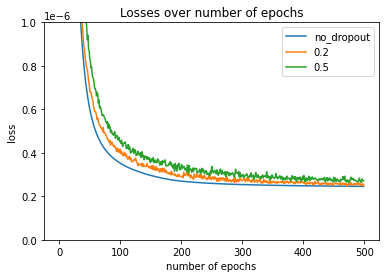

In [41]:
plot_loss(loss_values, lim=(0,1e-6))

In [42]:
def evaluate(nn1, X_train, y_train, X_test, y_test):
    # predicted classes for the training set - NN1
    y_pred_tr_nn1 = (nn1.forward(X_train).data.numpy() > 0.5).astype(int)
    
    # error for training set - NN1
    train_error_nn1 = zero_one_loss(y_train, y_pred_tr_nn1)

    # predicted classes for the test set - NN1
    y_pred_nn1 = (nn1.forward(X_test).data.numpy() > 0.5).astype(int)

    # error for test set - NN1
    test_error_nn1 = zero_one_loss(y_test, y_pred_nn1)

    # plot confusion matrix
    plt.matshow(confusion_matrix(y_test, y_pred_nn1))
    plt.title("NN1: training error = %.2f, test error = %.2f" % (train_error_nn1, test_error_nn1))
    plt.show()


no_dropout


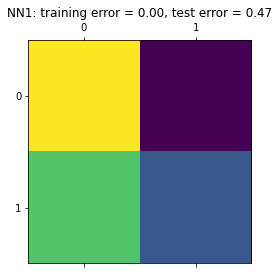

0.2


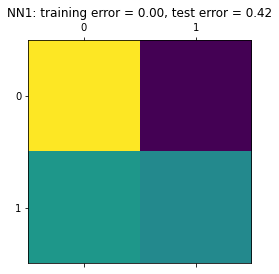

0.5


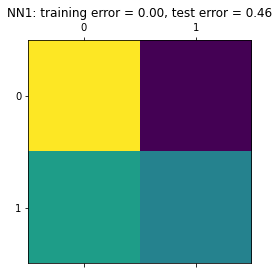

In [43]:
for model in models:
    print(model)
    evaluate(models[model], X_trainT, y_trainT, X_testT, y_testT)